# Librairies

In [58]:
import pandas as pd   
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.externals import joblib

# loading data

In [59]:
data = pd.read_csv("/content/drive/MyDrive/DATASETS/ML/P5/data_model.csv")

In [60]:
for col in data.columns:
  data[col] = data[col].astype("str")

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179953 entries, 0 to 179952
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Body_clean   179953 non-null  object
 1   Title_clean  179953 non-null  object
 2   Tags_clean   179953 non-null  object
 3   full         179953 non-null  object
dtypes: object(4)
memory usage: 5.5+ MB


In [62]:
data.head(5)

,Body_clean,Title_clean,Tags_clean,full
0,trying code two plot one plot underneath howev...,rearrange subplots one underneath,python matplotlib subplot,rearrange subplots one underneathtrying code t...
1,sometimes long list would like check whether s...,perl use junction inside regex interpolation,regex interpolation raku junction,perl use junction inside regex interpolationso...
2,set size image jekyll markdown steam fish asse...,set size rotate image jekyll,html markdown jekyll github pages,set size rotate image jekyllset size image jek...
3,command line argument defines type use vector ...,scons appending random macro definition osx,c macos g scons,scons appending random macro definition osxcom...
4,recently installed pyenv attempted install ver...,pyenv failed download existing version python,python macos pyenv,pyenv failed download existing version pythonr...


## Tags

In [63]:
# preparing data for OVR 
def tag_prep(string):
  return string.split()

tags = data["Tags_clean"].apply(tag_prep)

# Binarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags)

# transform target variable
y = multilabel_binarizer.transform(tags)

In [64]:
# checking shape
y.shape

(179953, 221)

# Supervised models

## Features

### Bag of Words model


#### Body

In [65]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
vectorizer = CountVectorizer(max_features = 250) 
# fit and transform
body_bow = vectorizer.fit_transform(data["Body_clean"])
# checking shape
body_bow.shape

(179953, 250)

#### Title

In [66]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
vectorizer = CountVectorizer(max_features = 750) 
# fit and transform
title_bow = vectorizer.fit_transform(data["Title_clean"])
#checking shape 
title_bow.shape

(179953, 750)

#### Stacking

In [67]:
# stacking features
X_bow = np.hstack([title_bow.toarray(),body_bow.toarray()])
# checking shape
X_bow.shape

(179953, 1000)

### TFIDF models

#### Body

In [68]:
# "CountVectorizer" 
body_count_vect = CountVectorizer(max_features = 250)
body_counts = body_count_vect.fit_transform(data["Body_clean"])

# tfidf transformer
body_Transformer = TfidfTransformer().fit(body_counts)
body_tfidf  = body_Transformer.transform(body_counts)
# checking chape
body_tfidf.shape

(179953, 250)

#### Title

In [69]:
# "CountVectorizer" 
title_count_vect = CountVectorizer(max_features = 750)
title_counts = title_count_vect.fit_transform(data["Title_clean"])
# tfidf transformer
title_Transformer = TfidfTransformer().fit(title_counts)
title_tfidf  = title_Transformer.transform(title_counts)
# checking chape
title_tfidf.shape

(179953, 750)

### Stacking

In [70]:
X_tfidf = np.hstack([title_tfidf.toarray(),body_tfidf.toarray()])
X_tfidf.shape

(179953, 1000)

## Modelisation

In [71]:
# Gridsearch params for

# Dummy
param_dummy = {'estimator__strategy': ["uniform","prior"]}

## NB
n_alphas = 10
alphas = np.logspace(-5, 5, n_alphas)

param_alpha = {'estimator__alpha': alphas} 

# SVM
param_svm = { 'estimator__C': [0.1, 1, 10],
             "estimator__penalty" : ["l1","l2"]}

# Using jaccard score micro for scoring
scoring = make_scorer(jaccard_score,greater_is_better=True, average = 'micro')

# Scoring lists
model_name = []
scores = []
features = []

# Cross validation state
cv = KFold(n_splits=5, shuffle=True, random_state=12)


In [72]:
# Defining models
models = []

models.append(("Dummy",OneVsRestClassifier(DummyClassifier()),param_dummy))
models.append(("Multinomial NB",OneVsRestClassifier(MultinomialNB()),param_alpha))
models.append(("SVC",OneVsRestClassifier(LinearSVC()),param_svm))


In [73]:
# features for loops
feats = []

feats.append((X_bow, "bow"))
feats.append((X_tfidf, "tf_idf"))

In [74]:
# looping trought features
for X, rep in feats:
  # splitting dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 5 )

  # Looping through models for gridsearch
  for name,model, params in models:
      print("building a model with:", name, "and",rep)
        
      # Fitting model
      model.fit(X_train,y_train)

      # make prediction
      y_pred = model.predict(X_test)

      # scoring
      score = round(jaccard_score(y_test, y_pred, average="micro"),2)
      
      # appending scoring list
      model_name.append(name)
      scores.append(score) 
      features.append(rep)

      print("Jaccard score with",name, "and ", rep, "is:" ,score)

building a model with: Dummy and bow
Jaccard score with Dummy and  bow is: 0.03
building a model with: Multinomial NB and bow
Jaccard score with Multinomial NB and  bow is: 0.11
building a model with: SVC and bow
Jaccard score with SVC and  bow is: 0.42
building a model with: Dummy and tf_idf
Jaccard score with Dummy and  tf_idf is: 0.03
building a model with: Multinomial NB and tf_idf
Jaccard score with Multinomial NB and  tf_idf is: 0.38
building a model with: SVC and tf_idf
Jaccard score with SVC and  tf_idf is: 0.46


## Performances

In [75]:
temp = { "Model" : model_name ,
        "Feature" : features,
        "Jaccard" : scores       
    
}
print("Number of tested models:",len(model_name))

Number of tested models: 6


In [76]:
scores = pd.DataFrame(temp)

scores["Model"] = scores["Model"].astype(str) + " with " + scores["Feature"].astype(str)
scores.sort_values("Jaccard", ascending=False, inplace=True)
scores["Jaccard"] = round(scores["Jaccard"].astype(float),2)
scores.reset_index(inplace=True, drop = True)
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = scores.style.background_gradient(cmap=cm)
s

,Model,Feature,Jaccard
0,SVC with tf_idf,tf_idf,0.460000
1,SVC with bow,bow,0.420000
2,Multinomial NB with tf_idf,tf_idf,0.380000
3,Multinomial NB with bow,bow,0.110000
4,Dummy with bow,bow,0.030000
5,Dummy with tf_idf,tf_idf,0.030000


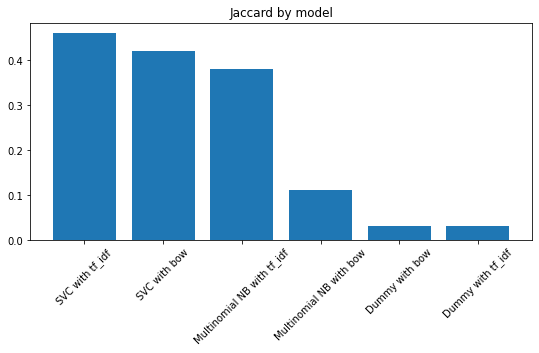

In [77]:
# ploting rmse score
plt.figure(figsize=(9,4))
plt.bar(scores["Model"],scores["Jaccard"])
plt.title("Jaccard by model")
plt.xticks(rotation=45)
plt.show()

## Gridsearch

In [78]:
X = X_tfidf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 5 )
print("Gridsearch with Linear SVC and tf- idf")
model = model_selection.GridSearchCV(
                OneVsRestClassifier(LinearSVC()),
                param_grid = param_svm ,     # hyperparamètres à tester
                cv=cv,           # nombre de folds de validation croisée
                scoring=scoring   # score à optimiser
              )

# Fitting model
model.fit(X_train,y_train)

# make prediction
y_pred = model.predict(X_test)

print("Gridsearch best params:",model.best_params_)

# scoring
score = round(jaccard_score(y_test, y_pred, average="micro"),2)

print("Gridsearch Jaccard score on test split:",score)

# make prediction
y_pred = model.predict(X_train)

# scoring
score = round(jaccard_score(y_train, y_pred, average="micro"),2)
print("Gridsearch Jaccard score on train split:",score)

Gridsearch with Linear SVC and tf- idf
Gridsearch best params: {'estimator__C': 1, 'estimator__penalty': 'l2'}
Gridsearch Jaccard score on test split: 0.46
Gridsearch Jaccard score on train split: 0.48


## Tags probability

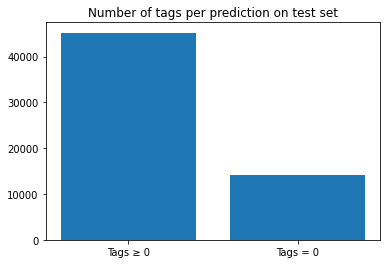

In [79]:
# predictiong test set
y_pred = model.predict(X_test)

# summing number of tags per predictions
nb_labels = []
for i in y_pred:
  nb_labels.append(sum(i))

# Counting nb of prediction with no tags
zero_label = 0
for i in nb_labels:
  if i ==0:
   zero_label +=1

# counting nb of prediction with at least one tag 
labels = 0
for i in nb_labels:
  if i !=0:
   labels +=1

# Bar plot for comparaison
height = [labels, zero_label]
bars = ("Tags ≥ 0", "Tags = 0")
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.title("Number of tags per prediction on test set")
# Show graphic
plt.show()


## EXPORT

In [80]:

joblib.dump(body_count_vect, 'body_count_vect.pkl')
joblib.dump(title_count_vect, 'title_count_vect.pkl')
joblib.dump(body_Transformer, 'body_Transformer.pkl')
joblib.dump(title_Transformer, 'title_Transformer.pkl')




['title_Transformer.pkl']

In [81]:
joblib.dump(multilabel_binarizer, 'multilabel_binarizer.pkl')
joblib.dump(model, 'classifier.pkl')

['classifier.pkl']

# NB predict = 0

# Unsupervised model

## Features

In [82]:
corpus = data["Title_clean"]+ data["Body_clean"]
corpus[0]

'rearrange subplots one underneathtrying code two plot one plot underneath however code keep aligning two plot next one another code import numpy np scipy integrate import odeint numpy import sin co pi array import matplotlib matplotlib import rcparams import matplotlib pyplot plt pylab import figure ax title show import xlsxwriter plt style use ggplot def deriv z l unextended length spring mass bob kg k spring constant nm g gravitational acceleration x dxdt dydt z dx dt l x dydt k x g co dy dt g sin dxdt dydt l x equation motion return np array dxdt dydt dx dt dy dt init array pi initial condition x xdot ydot time np linspace time interval start end number interval sol odeint deriv init time solving equation motion x sol sol fig ax ax plt subplots sharex true ax plot time x ax set ylabel hi ax plot time ax set ylabel fds plt plot keep getting result tried plt subplot x plt subplot plt show run error traceback recent call last file user cnoxon desktop python final code copy py line mod

In [83]:
# vectorizer
lda_count_vect = CountVectorizer(max_features = 250)

full_counts = lda_count_vect.fit_transform(corpus)
full_counts.shape

(179953, 250)

## Optimising topics number

Building model with: 40
Building model with: 60
Building model with: 80
Building model with: 100
Building model with: 120


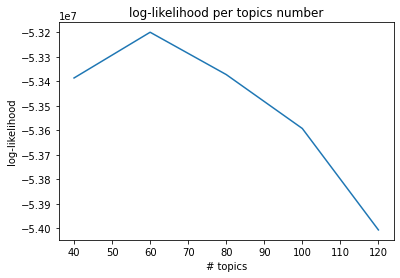

In [84]:
# optimising LDA with log likelihood

nb_topics = [40,60,80,100,120]
log_likelihood = []

for nb in nb_topics:
  print("Building model with:", nb)
  # Créer le modèle LDA
  lda = LatentDirichletAllocation(
          n_components=nb, 
          max_iter=5, 
          learning_method='online', 
          learning_offset=50.,
          random_state=0)

  # Fitter sur les données
  lda.fit(full_counts)
  log_likelihood.append(lda.score(full_counts))


import matplotlib.pyplot as plt


plt.plot(nb_topics, log_likelihood)
plt.title("log-likelihood per topics number")
plt.xlabel("# topics")
plt.ylabel("log-likelihood")
plt.show()

## LDA with optimal nb topics

In [85]:
n_topics = 60

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(full_counts)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=60, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [86]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 4
display_topics(lda, lda_count_vect.get_feature_names(), no_top_words)

Topic 0:
script src html package
Topic 1:
base component new problem
Topic 2:
version build flutter dependency
Topic 3:
string library let io
Topic 4:
test result running case
Topic 5:
log console let debug
Topic 6:
text content title document
Topic 7:
key message base get
Topic 8:
div view display container
Topic 9:
type object ha method
Topic 10:
name input output np
Topic 11:
request api service response
Topic 12:
http com project example
Topic 13:
using work code use
Topic 14:
import target export main
Topic 15:
python py lib file
Topic 16:
self image def return
Topic 17:
int main void static
Topic 18:
class button want another
Topic 19:
default config init path
Topic 20:
public string private class
Topic 21:
model size load length
Topic 22:
error date failed code
Topic 23:
list item map want
Topic 24:
data column row index
Topic 25:
like would way example
Topic 26:
function return result print
Topic 27:
page element link update
Topic 28:
number line variable method
Topic 29:
state

## EXPORT

In [87]:
from sklearn.externals import joblib
joblib.dump(lda_count_vect, 'lda_count_vect.pkl')
joblib.dump(lda, 'lda_model.pkl')

['lda_model.pkl']